# The effect of a Language Model

Up to now, the transcript the ASR system generates is through an “end-to-end” [CTC-based network]( https://www.cs.toronto.edu/~graves/icml_2006.pdf) which matches audio and text without additional alignment information. However, ambiguities in the transcription, for example when collapsing repeated characters and removing blanks, can exist as the CTC-based network has little prior linguistic knowledge. This is where a language model comes in, as it can help solve those decoding ambiguities.

Specifically, the decoder output or transcript, when introducing a language model, is dependent on both the CTC network (softmax) output and the language model prediction. The language model we use is based on prefix beam search [KenLM]( https://github.com/kpu/kenlm) which imposes a language model constraint on the new predicted character based on previous (most probable) prefixes. To learn more see [First-Pass Large Vocabulary Continuous Speech Recognition using Bi-Directional Recurrent DNNs](https://arxiv.org/pdf/1408.2873.pdf).

In this notebook we evaluate the effect in performance of `adding a Language Model `. The model we use and train is the [Baidu’s CTC decoder with N-Gram LM implementation](https://github.com/PaddlePaddle/DeepSpeech).

**Note**: If you wish to use a language model in your ASR pipeline, you need to install the necessary software. Please refer to the Dockerfile in `/tmp/nemo_asr_app/Dockerfile` and re-build the container.

In [1]:
# required imports
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from easydict import EasyDict as edict

from tools.System.config import cfg
from tools.System.reader import Reader
from tools.misc import parse_manifest_wer, barplot_manifest, get_transcript, get_gtruth

# 1. Load previous project
In Step 1 - Acoustic Model workflow, we created a project that keeps track of the datasets, configurations and models created. 
Everything related to a project is saved in disc in a manifest that can be access through its `project_id`.

At the start of the project, the manifest is pre-populated with the baseline pretrained models. For acoustic model we use a pretrained model on LibriSpeech with a greedy decoder and for language model we use a Baidu's CTC decoder model. Both pre-trained models were built or downloaded in `Step 0` and thus exist in the `example_data` folder.

Next, we load the project we created when doing the acoustic model workflow. 

In [2]:
project_id = 'WSJ'
project = Reader.load_manifest(project_id, Reader)
# project.manifest.lm

Manifest restored from /raid/datasets/asr/data/manifests/WSJ_manifest.json 



#  2. Training a Language Model on Domain Data
Next, we train a language model with our own data.

The steps are: 1. Add pre-processed dataset to project, 2. Edit training parameters 3. Generate training command and perform training.

Note, if the WSJ is not available to you, you can download the trained WSJ language model (used to generate the results of this notebook) from NGC in this [link](https://ngc.nvidia.com/models/nvidia:wsj_lm_decoder). Then you must place the binary file in the following path: `[data_dir]/models/language_models/`[WS_lm.binary]

## 2.1 Add LM Dataset to project
To train a language model you require the pre-processed training text as a single column (per sentence) saved as a .txt file.

In [3]:
lm_txt = os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA,'wsj','lm',"wsj-lm-data.txt")

project.add_dataset(lm_txt, "LM-WSJ", dataset_type="lm-train")
project.manifest.lm

{'train_dataset_name': 'LM-WSJ',
 'train_dataset': '/raid/datasets/asr/data/example_data/wsj/lm/wsj-lm-data.txt',
 'ngram': 6,
 'finetuned_model': '/raid/datasets/asr/data/models/language_models/WSJ_lm.binary',
 'train_cmd': None,
 'infer_cmd': None}

## 2.2 Edit Training Parameters
We first edit language model training parameters. Here the only parameter to edit is the length of the sequence of words `(N)` used by the N-gram model.

In [4]:
# edit parameters
project.set_n_gram(6) # number of words for N-Gram
project.manifest.lm

{'train_dataset_name': 'LM-WSJ',
 'train_dataset': '/raid/datasets/asr/data/example_data/wsj/lm/wsj-lm-data.txt',
 'ngram': 6,
 'finetuned_model': '/raid/datasets/asr/data/models/language_models/WSJ_lm.binary',
 'train_cmd': None,
 'infer_cmd': None}

## 2.3 Training
The following function will generate the language model training command for our dataset. You can run this command directly in this notebook or in the container terminal.

In [5]:
lm_train_cmd = project.get_lm_train_cmd()
print ("! " + lm_train_cmd)

! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/build_lm.py /raid/datasets/asr/data/example_data/wsj/lm/wsj-lm-data.txt --n=6 --project_id=WSJ


In [6]:
# clean log directory to re-run the training 
#project.clean_lm_logdir()

Copy (select cmd + shift RMB + copy) the command generated and paste it below to run training inside the notebook, you can also run it inside the container's terminal.

In [7]:
# ! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/build_lm.py /raid/datasets/asr/data/example_data/wsj/lm/wsj-lm-data.txt --n=6 --project_id=WSJ

# 3. Inference with Pre-trained and Fine-tuned Models
Next, we perform inference with both the pre-trained and fine-tuned models.

The steps are: 
1. Add pre-processed evaluation datasets to project
2. Inference using: Finetuned AM with Pre-trained LM model
3. Inference using: Finetuned AM with Fine-tuned LM model

## 3.1. Add Inference Evaluation Datasets to the Project 
To perform inference you require a preprocessed `json` dataset, with the columns: `audio_filepath`, `duration` and `text`.

In [8]:
# add inference dataset
eval_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj","wsj-eval-92.json")
#eval_json=os.path.join(cfg.DATASET.PATHS.EXAMPLE_DATA, "wsj","wsj-dev-93.json")

project.add_dataset(eval_json, "wsj-eval", dataset_type="eval")

# Becuase we already added the evaluation dataset to project when doing the AM workflow we don't need to do it again
print(project.manifest.eval_dataset_names)
print(project.manifest.eval_datasets)

wsj-eval is already included in the eval dataset
['wsj-eval']
['/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json']


## 3.2 Inference with Pre-trained LM model and Fine-tuned AM model
To do inference, we follow 3 steps: 1) Adjust inference parameters. 2) Generate inference command 3) Perform inference

### 3.2.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_eval.py`.

Important Notes:
- The parameter `amp_opt_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

- When `lm_path` is set to "None", the system will use a `greedy decoder`, and thus the language model parametrs `beam_width`, `alpha`, `beta` will not be used.

In [9]:
project.manifest.inference_params

{'load_dir': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned',
 'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O0',
 'save_results': '/raid/datasets/asr/data/inferences/WSJ',
 'lm_path': None,
 'beam_width': None,
 'alpha': None,
 'beta': None}

### Add Language Model Inference Parameters 
In this section we **must** set the LM parameters to enable inference with the beam-search decoder. 

When decoding with a language model, we accumulate the log probabilities from an acoustic model (using logits) in different hypotheses/candidates (beams), where a larger `beam_width` accommodates more candidates. Each time we append a space character to some candidate, it means that we finished some word. At that point, the beam's score is updated with the LM score (probability of N previous words - including newly added word). 

The beam score is calculated as: `beam_score += alpha*LM_score + beta` 

The parameters to change are:
- `lm_path`: Pointing to the `binary` file of the LM model you wish to use. The function project.get_path_to_lm(LM_finetuned=False) will return the path project's pre-trained or fine-tuned models.
- `beam_width`: determining how many prefixes (beams) will be selected at each timestep.
- `alpha`: the weight of the language model.
- `beta`: compensation term or word insertion weight. Required to control length of candidates (balance number of words).

#### Alpha and Beta tuning
The `/tools/NeMo/jasper_eval.py` script has the ability to sweep `alpha` and `beta` hyperparameters for tuning. To create a grid search across these parameters you need to add a parameter `max` and `step`, for example: `--alpha=1.0 --alpha_max=3.0 --alpha_step=1.0` for alpha and `--beta=0.1 --beta_max=0.4 --beta_step=0.1` for beta.

In [10]:
# add pretrained language model
project.manifest.inference_params.lm_path = project.get_path_to_lm(LM_finetuned=False) # pre-trained model (lm)
# beam parameters
project.manifest.inference_params.beam_width = 200
project.manifest.inference_params.alpha = 3.0
project.manifest.inference_params.beta = 0.1
# other parameters
project.manifest.inference_params.batch_size = 32
project.manifest.inference_params.amp_opt_level = 'O1'

project.save_manifest()
project.manifest.inference_params

{'load_dir': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned',
 'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O1',
 'save_results': '/raid/datasets/asr/data/inferences/WSJ',
 'lm_path': '/raid/datasets/asr/data/example_data/language_model/6-gram-lm.binary',
 'beam_width': 200,
 'alpha': 3.0,
 'beta': 0.1}

### 3.2.2 Generate Inference Command for Pre-trained LM Model
We generate the inference command using the manifest configurations.

In [11]:
# Model Id - We use this to identify the results of this model
model_id = "am-finetuned-WSJ_train_speed--lm-Libri"

# Inference with Pretrained model
lm_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ lm_infer_cmd)

! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/raid/datasets/asr/data/inferences/WSJ --lm_path=/raid/datasets/asr/data/example_data/language_model/6-gram-lm.binary --beam_width=200 --alpha=3.0 --beta=0.1 --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed--lm-Libri


### 3.2.3 Run Inference with LibriSpeech LM Model
To run inference, copy (select cmd + shift RMB + copy) the command generated above and paste below.

In [12]:
! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/raid/datasets/asr/data/inferences/WSJ --lm_path=/raid/datasets/asr/data/example_data/language_model/6-gram-lm.binary --beam_width=200 --alpha=3.0 --beta=0.1 --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed--lm-Libri

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
Could not import torchaudio. Some features might not work.
2019-12-15 21:20:58,817 - INFO - Dataset loaded with 0.71 hours. Filtered 0.00 hours.
2019-12-15 21:20:58,818 - INFO - Evaluating 333 examples
2019-12-15 21:20:58,818 - INFO - PADDING: 16
2019-12-15 21:20:58,819 - INFO - STFT using conv
2019-12-15 21:21:01,042 - INFO - ================================
2019-12-15 21:21:01,045 - INFO - Number of parameters in encoder: 18894656
2019-12-15 21:21:01,045 - INFO - Number of parameters in decoder: 29725
2019-12-15 21:21:01,048 - INFO - Total number of parameters: 18924381
2019-12-15 21:21:01,048 - INFO - ================================
2019-12-15 21:21:01,055 - INFO - Restoring JasperEncoder from /home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned/JasperEncoder-STEP-17400

## 3.3 Inference with Fine-tuned model
To do inference with our fine-tuned model, we must modify the manifest parameters to point to our fine-tuned model, then follow the same process as before.

### 3.3.1 Modify inference parameters
The default inference parameters are specified in the project manifest, inference script and the configuration file. However, you can modify some of these parameters as follows.

To see the full list of parameters accessible by the manifest see `project.manifest.inference_params`, to see other parameters look at the NeMo inference script at `/tools/NeMo/jasper_eval.py`.

### Add Language Model Inference Parameters 
In this section we **need to** set the LM parameters to enable inference with the beam-search decoder, specifically the fine-tuned LM model.

The parameters to change are:
- `lm_path`: Pointing to the `binary` file of the LM model you wish to use. The function project.get_path_to_lm(LM_finetuned=False) will return the path project's pre-trained or fine-tuned models.
- `beam_width`: determining how many prefixes (beams) will be selected at each timestep.
- `alpha`: the weight of the language model.
- `beta`: compensation term or word insertion weight. Required to control length of candidates (balance number of words).

#### Alpha and Beta tuning
The `/tools/NeMo/jasper_eval.py` script has the ability to sweep `alpha` and `beta` hyperparameters for tuning. To create a grid search across these parameters you need to add a parameter `max` and `step`, for example: `--alpha=1.0 --alpha_max=3.0 --alpha_step=1.0` for alpha and `--beta=0.1 --beta_max=0.4 --beta_step=0.1` for beta.

In [13]:
# Path to the fine-tuned lm model
project.get_path_to_lm(LM_finetuned=True)

'/raid/datasets/asr/data/models/language_models/WSJ_lm.binary'

In [14]:
# Inference with Fintuned language model
project.manifest.inference_params.lm_path = project.get_path_to_lm(LM_finetuned=True)
# beam parameters
project.manifest.inference_params.beam_width = 200
project.manifest.inference_params.alpha = 3.0
project.manifest.inference_params.beta = 0.1

# other parameters
project.manifest.inference_params.batch_size = 32
project.manifest.inference_params.amp_opt_level = 'O1'

project.save_manifest()
project.manifest.inference_params

{'load_dir': '/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned',
 'model_config': '/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml',
 'batch_size': 32,
 'amp_opt_level': 'O1',
 'save_results': '/raid/datasets/asr/data/inferences/WSJ',
 'lm_path': '/raid/datasets/asr/data/models/language_models/WSJ_lm.binary',
 'beam_width': 200,
 'alpha': 3.0,
 'beta': 0.1}

### 3.3.2 Generate Inference Command
We generate the inference command using the manifest configurations.

In [15]:
# Model Id - We use this to identify the results of this model
model_id = "am-finetuned-WSJ_train_speed--lm-WSJ"
# Inference with Pretrained model
lm_infer_cmd = project.get_inference_cmd(model_id=model_id)
print("! "+ lm_infer_cmd)

! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/raid/datasets/asr/data/inferences/WSJ --lm_path=/raid/datasets/asr/data/models/language_models/WSJ_lm.binary --beam_width=200 --alpha=3.0 --beta=0.1 --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed--lm-WSJ


### 3.3.3 Run Inference with Finetuned Model
To run inference, copy (Shift + Left Mouse click, Copy) the command generated above and paste below.

In [16]:
! python /home/adrianaf/projects/asr_system/nemo_asr_app/tools/NeMo/jasper_eval.py --load_dir=/home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned --model_config=/raid/datasets/asr/data/config_files/WSJ_acoustic_quartznet15x5.yaml --batch_size=32 --amp_opt_level=O1 --save_results=/raid/datasets/asr/data/inferences/WSJ --lm_path=/raid/datasets/asr/data/models/language_models/WSJ_lm.binary --beam_width=200 --alpha=3.0 --beta=0.1 --eval_datasets=/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json --model_id=am-finetuned-WSJ_train_speed--lm-WSJ

/opt/conda/lib/python3.6/site-packages/torchvision/io/_video_opt.py:17: UserWarning: video reader based on ffmpeg c++ ops not available
  warnings.warn("video reader based on ffmpeg c++ ops not available")
Could not import torchaudio. Some features might not work.
2019-12-15 21:21:41,683 - INFO - Dataset loaded with 0.71 hours. Filtered 0.00 hours.
2019-12-15 21:21:41,684 - INFO - Evaluating 333 examples
2019-12-15 21:21:41,685 - INFO - PADDING: 16
2019-12-15 21:21:41,685 - INFO - STFT using conv
2019-12-15 21:21:43,775 - INFO - ================================
2019-12-15 21:21:43,778 - INFO - Number of parameters in encoder: 18894656
2019-12-15 21:21:43,778 - INFO - Number of parameters in decoder: 29725
2019-12-15 21:21:43,781 - INFO - Total number of parameters: 18924381
2019-12-15 21:21:43,781 - INFO - ================================
2019-12-15 21:21:43,788 - INFO - Restoring JasperEncoder from /home/adrianaf/projects/asr_system/nemo_asr_app/demo/finetuned/JasperEncoder-STEP-17400

# 4. Results and Model Comparison

## 4.1 Add Inference results to manifest
We first add the results from our inference runs to the project's manifest.

In [17]:
project.add_inference_results()

Added results for model am-finetuned-WSJ_train_speed--lm-Libri - /raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json.
Results for model 'am-finetuned-WSJ_train_speed-greedy-decoder' already exists - to replace delete prior results).
Results for model 'am-pretrained-greedy-decoder' already exists - to replace delete prior results).
Added results for model am-finetuned-WSJ_train_speed--lm-WSJ - /raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json.


Now that the inference results are added, we can see them in the manifest. 
The results are structured as follows: For each evaluation dataset, we have a multiple models identified by their `model_id` and inside those we have the model's results.

In [18]:
inf_datasets = list(project.manifest.inference.keys())
print("Datasets with inference: ", inf_datasets)

for inf in inf_datasets:
    print()
    print(inf)
    print(project.manifest.inference[inf])

Datasets with inference:  ['/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json']

/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json
{'am-finetuned-WSJ_train_speed-greedy-decoder': {'wer': 0.044657097288676235, 'path': '/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-finetuned-WSJ_train_speed-greedy-decoder.json', 'lm_wer': None}, 'am-pretrained-greedy-decoder': {'wer': 0.09994683678894205, 'path': '/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-pretrained-greedy-decoder.json', 'lm_wer': None}, 'am-finetuned-WSJ_train_speed--lm-Libri': {'wer': 0.044479886585149744, 'path': '/raid/datasets/asr/data/inferences/WSJ/results-lm_grid__wsj-eval-92__am-finetuned-WSJ_train_speed--lm-Libri.json', 'lm_wer': 0.037037037037037035}, 'am-finetuned-WSJ_train_speed--lm-WSJ': {'wer': 0.044657097288676235, 'path': '/raid/datasets/asr/data/inferences/WSJ/results-lm_grid__wsj-eval-92__am-finetuned-WSJ_train_speed--lm-WSJ.json', 'lm_wer': 0.0241

To obtain the `Transcript` and `Ground Truth` from an evaluation dataset, you can use the commands `get_transcript` and `get_gtruth` using the path to the inference results which can be obtained by `project.get_inf_path`.

In [19]:
# to get the path to the inference results - you need the dataset path and the model-id you wish to retrieve
#path = project.get_inf_path('/raid/datasets/asr/data/example_data/wsj/wsj-dev-93.json',
path = project.get_inf_path('/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json',
                            'am-finetuned-WSJ_train_speed--lm-WSJ')
print(path)

transcript = get_transcript(path, lm=True) # get transcript generated by the LM
gtruth = get_gtruth(path)
print(transcript)

/raid/datasets/asr/data/inferences/WSJ/results-lm_grid__wsj-eval-92__am-finetuned-WSJ_train_speed--lm-WSJ.json
dravo last month agreed in principle to sell its inland water transportation stevedoring and pipe fabrication businesses for an undisclosed sum the combined businesses accounted for two hundred thirty five million dollars of dravo's eight hundred ninety three million dollars in nineteen eighty five revenue in september the company received ninety six point eight million dollars as its share of damages from a breach of contract award related to a coal partnership south africa the solution by francis kendall and leon louw has sold over twenty five thousand copies since last year as miss kendell and mister lowe set south africa's central government is like a big lumbering tank white bureaucrats are in the driver's seat and blacks rightly fear what the tank weapons can do to them many want to storm the tank and take it over but if the history of other african nations is any guide 

## 4.2 Model Comparison
Next, we compare the Word Error Rates for both the fine-tuned model and pre-trained model.

In [20]:
inferences_all = list(project.manifest.inference.keys())
inferences_all.sort()
print(inferences_all)

['/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json']


We select one eval dataset to plot its performance. We also select the performance metric we wish to sort by.

Note, if `lm_wer` is present we chose that value over the `wer` value.

In [21]:
sel_inference = project.manifest.inference[inferences_all[0]]
sel_inference

{'am-finetuned-WSJ_train_speed-greedy-decoder': {'wer': 0.044657097288676235,
  'path': '/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-finetuned-WSJ_train_speed-greedy-decoder.json',
  'lm_wer': None},
 'am-pretrained-greedy-decoder': {'wer': 0.09994683678894205,
  'path': '/raid/datasets/asr/data/inferences/WSJ/results-am_grid__wsj-eval-92__am-pretrained-greedy-decoder.json',
  'lm_wer': None},
 'am-finetuned-WSJ_train_speed--lm-Libri': {'wer': 0.044479886585149744,
  'path': '/raid/datasets/asr/data/inferences/WSJ/results-lm_grid__wsj-eval-92__am-finetuned-WSJ_train_speed--lm-Libri.json',
  'lm_wer': 0.037037037037037035},
 'am-finetuned-WSJ_train_speed--lm-WSJ': {'wer': 0.044657097288676235,
  'path': '/raid/datasets/asr/data/inferences/WSJ/results-lm_grid__wsj-eval-92__am-finetuned-WSJ_train_speed--lm-WSJ.json',
  'lm_wer': 0.02410065567960305}}

We select one eval dataset to plot its performance and we also select the performance metric we wish to sort by.

In [22]:
sort_metric = 'percentWER'
# Note if you wish to plot (and parse) only a specific set of models you can use the argument 'keep' and 
# list the model_id(s) you wish to keep.
lm_df = parse_manifest_wer(sel_inference, sort_metric=sort_metric)
                           
print(inferences_all[0])
lm_df

/raid/datasets/asr/data/example_data/wsj/wsj-eval-92.json


,inference_types,lm_wer,wer,percentWER
3,am-finetuned-WSJ_train_speed--lm-WSJ,0.024101,0.044657,2.410066
2,am-finetuned-WSJ_train_speed--lm-Libri,0.037037,0.044480,3.703704
0,am-finetuned-WSJ_train_speed-greedy-decoder,NaN,0.044657,4.465710
1,am-pretrained-greedy-decoder,NaN,0.099947,9.994684


We use the dataframe created by the `parse_manifest_wer` function to plot the performance of the different models.
We use the function `barplot_manifest` that has the arguments `([dataframe],[metric to plot],[title],[xlabel],[ylabel])`.

Note: WER percent may be above 100% when the number of words in the prediction is larger than the number of words in the reference.

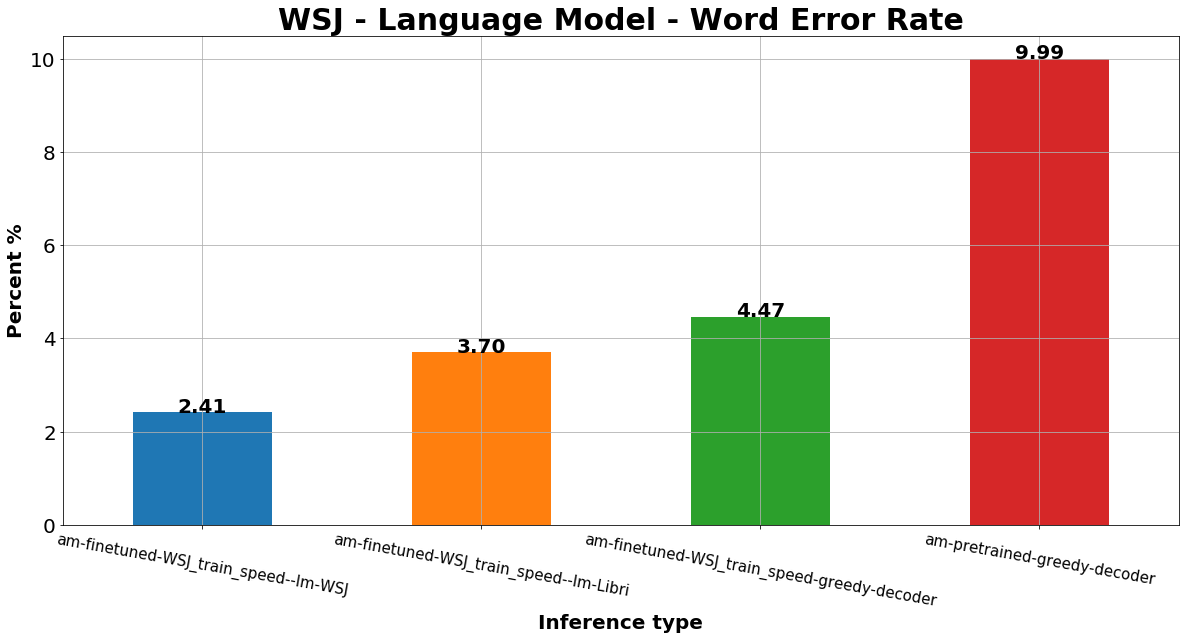

In [23]:
%matplotlib inline
lm_wer = barplot_manifest(lm_df,'percentWER',"WSJ - Language Model - Word Error Rate", "Inference type","Percent %")

## 5. WER effect of Language Model
As shown in the plot, adding a Language Model improves model performance by a few percent, and this improvement is even larger when the LM is trained on domain data.

In [24]:
lm_df.set_index('inference_types', inplace=True)

In [25]:
org = lm_df.loc['am-pretrained-greedy-decoder','wer'] # pre-trained model
new = lm_df.loc['am-finetuned-WSJ_train_speed--lm-WSJ','lm_wer'] # fine-tuned am and lm model

In [26]:
per_decrease = 100*((org-new)/org)
print("Decreased WER by {0:.2f}%".format(per_decrease))

Decreased WER by 75.89%
